In [649]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan 
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Create SwanGraph

In [650]:
annot = '../../refs/gencode_v29_sirv4_ercc.gtf'
ab = '../talon/human_talon_abundance_filtered.tsv'
gtf = '../talon/human_known_nic_nnc_talon.gtf'

In [654]:
sg = swan.SwanGraph()
sg.add_annotation(annot)
sg.add_transcriptome(gtf)
sg.add_abundance(ab)

In [653]:
sg.save_graph('swan')

Saving graph as swan.p


## Get metadata

In [655]:
sg = swan.read('swan.p')
meta = sg.adata.obs.copy(deep=True)
meta.reset_index(inplace=True, drop=True)
meta['sample'] = meta.dataset.str.rsplit('_', n=2, expand=True)[0]

tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'sample']]
tissue_df.rename({'sample': 'sample'}, axis=1, inplace=True)

meta = meta.merge(tissue_df, how='left', on='sample')
meta.head()
meta['classification'] = 'tissue'
meta.loc[meta.tissue.isnull(), 'classification'] = 'cell_line'

meta.loc[meta.tissue.isnull(), 'tissue'] = meta.loc[meta.tissue.isnull(), 'sample']
meta.drop('sample', axis=1, inplace=True)
meta.rename({'tissue': 'sample'}, axis=1, inplace=True)

print('Found {} total samples'.format(len(meta['sample'].unique().tolist())))

Read in graph from swan.p
Found 49 total samples


In [656]:
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

## Add metadata

In [661]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [662]:
meta = 'swan_metadata.tsv'
sg.add_metadata('swan_metadata.tsv')

# colors
c_dict, order = get_sample_colors()
sg.set_metadata_colors('sample', c_dict)

sg.save_graph('swan')

Saving graph as swan.p


## Pi / major isoform stuff

Read in graph from swan.p


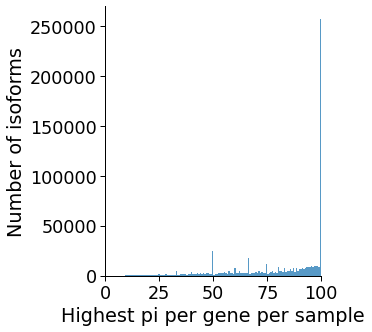

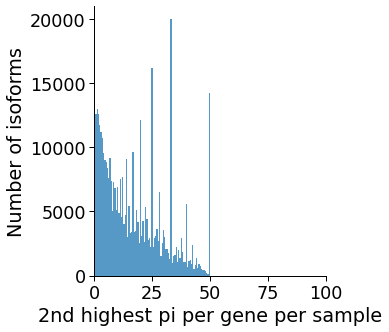

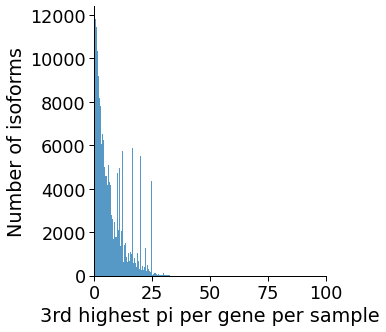

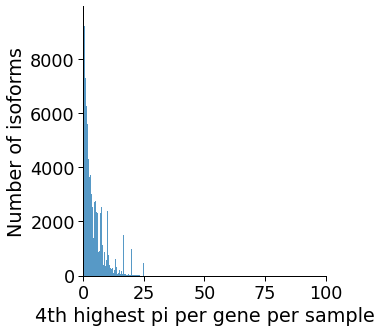

In [663]:
sg = swan.read('swan.p')
plot_major_iso_pis(sg, 'sample', opref='figures/human')

### How many isoforms does it take to get 90% expression / gene / sample?

In [664]:
sg = swan.read('swan.p')
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')

Read in graph from swan.p


In [665]:
t_df = t_df[['annot_gene_name', 'annot_transcript_id', 'annot_gene_id']]
t_df.rename({'annot_gene_name': 'gname',
             'annot_gene_id': 'gid',
             'annot_transcript_id': 'tid'}, 
             axis=1, 
             inplace=True)

df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col='sample')
df = df.sparse.to_dense()
df = df.transpose()
df = df.merge(t_df[['tid', 'gname', 'gid']], how='inner', on='tid')

df.set_index(['tid', 'gname', 'gid'], inplace=True)
df = df.melt(ignore_index=False, value_name='pi', var_name='sample')
df = df.dropna(subset=['pi'])
df.reset_index(inplace=True)

# determine the rank of each pi value for each sample / gene combo
df = df.sort_values(by='pi', ascending=False)
df['pi_rank'] = df.sort_values(by='pi', ascending=False).groupby(['gname', 'gid', 'sample']).cumcount()+1

# add a column that we can check for convergence with 
df['gname_gid_biosamp'] = df.gname+'_'+df.gid+'_'+df.sample

iso_df = pd.DataFrame()
max_pi_rank = df.pi_rank.max()
for max_pi in range(1, max_pi_rank+1):
    pi_ranks = [i for i in range(1, max_pi+1)]
    # for the first iteration, we don't have to limit which genes we look at
    if max_pi == 1:
        temp = df.loc[df.pi_rank.isin(pi_ranks)].groupby(['gname_gid_biosamp']).sum().reset_index()
    else:
        ids = iso_df.gname_gid_biosamp.tolist()
        temp = df.loc[(~df.gname_gid_biosamp.isin(ids))&(df.pi_rank.isin(pi_ranks))].groupby(['gname_gid_biosamp']).sum().reset_index()
    
    # converged if no more entries to analyze
    if len(temp.index) == 0:
        break
    
    # get isoforms that have >90% isoform exp accounted for
    temp = temp.loc[temp.pi >= 90]
    temp.drop(['pi_rank'], axis=1, inplace=True)
    temp['n_isos'] = max_pi
    
    iso_df = pd.concat([iso_df, temp])

# get list of isoforms required for each sample / gene combination as well
df = df.merge(iso_df, how='left', on='gname_gid_biosamp')
df['in_90_set'] = df.pi_rank <= df.n_isos
df = df.loc[df.in_90_set]
df[['gname', 'gid', 'sample']] = df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
df.rename({'pi_x': 'pi'}, axis=1, inplace=True)
df.drop(['gname_gid_biosamp', 
        'pi_y', 'n_isos', 'in_90_set'], axis=1, inplace=True)

# get the sample / gene vs. n isoforms required for 90%    
iso_df[['gname', 'gid', 'sample']] = iso_df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
iso_df.drop('gname_gid_biosamp', axis=1, inplace=True)
iso_df = iso_df.sort_values('n_isos', ascending=False)

In [666]:
df.to_csv('isos_sample_gene_90.tsv', sep='\t', index=False)

In [667]:
df.head()

,tid,gname,gid,biosample,pi,pi_rank
0,ENST00000354258.4,TAP1,ENSG00000168394.11,h1,100.0,1
1,ENST00000574501.1,SMG6,ENSG00000070366.13,adipose,100.0,1
2,ENST00000492880.1,AC108751.5,ENSG00000244503.1,hct116,100.0,1
3,ENST00000620344.1,AC139530.3,ENSG00000275902.1,vessels,100.0,1
4,ENST00000344595.9,SRR,ENSG00000167720.12,adipose,100.0,1


In [668]:
iso_df.to_csv('n_isos_sample_gene_90.tsv', sep='\t', index=False)

In [669]:
opref = 'figures/human'

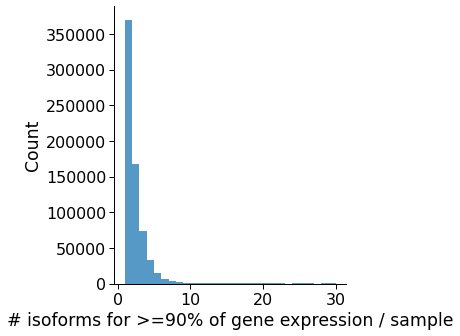

In [670]:
sns.set_context('paper', font_scale=1.8)
ax = sns.displot(data=iso_df, x='n_isos',
                 kind='hist',
                 binwidth=1,
                 linewidth=0)

xlabel = '# isoforms for >=90% of gene expression / sample'
ylabel = 'Count'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}_isos_pi_90.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')   

### Gene-level exon analysis

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687
Found 49 total samples


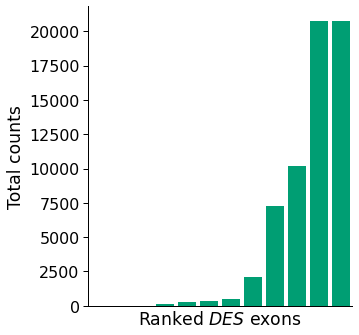

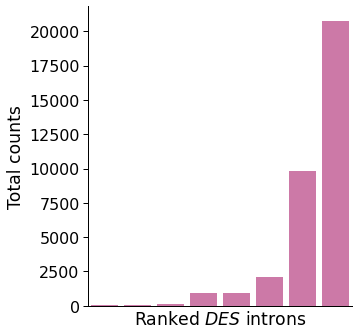

In [2]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'DES', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687
Found 49 total samples


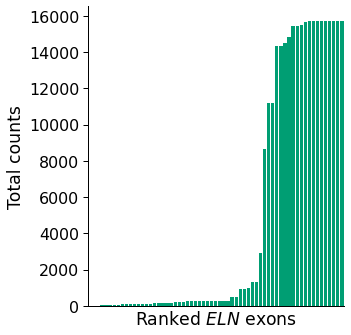

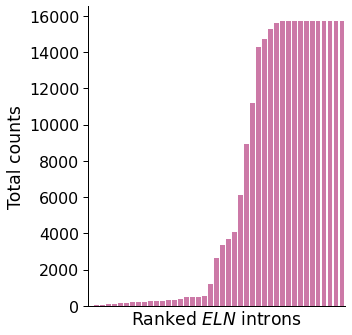

In [3]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'ELN', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687
Found 49 total samples
Found 139 isoforms for ELN


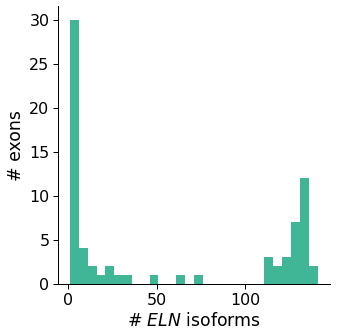

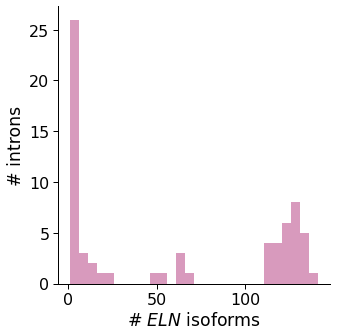

In [4]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_exon_hist(sg, df, 'ELN',
               min_tpm=1,
               gene_subset='polya',
               sample='all', 
               groupby='sample', 
               nov=['Known', 'NIC', 'NNC'], 
               opref='figures/human')

In [5]:
sg.plot_graph('ELN', indicate_novel=True, prefix='figures/eln')

Saving summary graph for ENSG00000049540.16 as figures/eln_novel_ENSG00000049540.16_summary.png


In [6]:
sg.plot_graph('DES', indicate_novel=True, prefix='figures/des')

Saving summary graph for ENSG00000175084.11 as figures/des_novel_ENSG00000175084.11_summary.png


In [7]:
sg.plot_transcript_path('ENST00000373960.3', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENST00000373960.3 as figures/des_novel_ENST00000373960.3_path.png


In [8]:
sg.plot_transcript_path('ENCODEHT002835059', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENCODEHT002835059 as figures/des_novel_ENCODEHT002835059_path.png


## Reports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan 
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [3]:
c_dict, order = get_biosample_colors()

In [4]:
sg.adata.obs.head()

,dataset,total_counts,sample,classification
index,,,,
gm12878_1_1,gm12878_1_1,599462.0,gm12878,cell_line
gm12878_1_2,gm12878_1_2,520625.0,gm12878,cell_line
gm12878_1_3,gm12878_1_3,453713.0,gm12878,cell_line
gm12878_1_4,gm12878_1_4,567895.0,gm12878,cell_line
gm12878_3_1,gm12878_3_1,886624.0,gm12878,cell_line


In [7]:
def make_biosamp_reports(sg, gene, order):
    def make_reports(sg, gene, c, order):
        opref = 'figures/{}_{}'.format(gene.lower(), c)
        samples = list(set(order)&set(sg.adata.obs.loc[sg.adata.obs.classification == c, 'sample'].unique().tolist()))
        sg.gen_report(gene,
                  prefix=opref,
                  layer='pi',
                  cmap='magma',
                  novelty=True,
                  groupby='sample',
                  metadata_cols=['sample'],
                  datasets={'sample': samples},
                  transcript_col='tname',
                  browser=True)

        sg.gen_report(gene,
                      prefix=opref,
                      layer='tpm',
                      cmap='viridis',
                      novelty=True,
                      groupby='sample',
                      metadata_cols=['sample'],
                      indicate_novel=True,
                      transcript_col='tname',
                      datasets={'sample': samples})
        
    c = 'tissue'
    make_reports(sg, gene, c, order)
    c = 'cell_line'
    make_reports(sg, gene, c, order)    

In [8]:
make_biosamp_reports(sg, 'COL1A1', order)


Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_tissue_browser_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_tissue_browser_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000463440.1 as figures/col1a1_tissue_browser_ENST00000463440.1_path.png
Generating report for ENSG00000108821.13
                     vessels  muscle  heart  colon      ovary  kidney  \
tid                                                                     
ENST00000225964.9  99.817520   100.0  100.0  100.0  99.909828   100.0   
ENST00000510710.3   0.182482     0.0    0.0    0.0   0.000000     0.0   
ENST00000463440.1   0.000000     0.0    0.0    0.0   0.090171     0.0   

                   adipose  adrenal gland  liver   lung novelty       tname  
tid                                                                          
ENST00000225964.9    100.0          100.0  100.0  100.0   K

In [18]:
make_biosamp_reports(sg, 'CAST')


Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_browser_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_browser_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_browser_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_browser_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_browser_E

In [19]:
make_biosamp_reports(sg, 'GGT1')


Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_browser_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_browser_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_browser_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_browser_E

In [20]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_pi',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'classification': 'cell_line'},
              browser=True)


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_pi_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_pi_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_pi_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_pi_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_pi_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_pi_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_pi_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_pi_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENCODEHT

In [32]:
samples = [o for o in order if o in sg.adata.obs.loc[sg.adata.obs.classification == 'cell_line', 'sample'].tolist()]
print(samples)
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_tpm',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'sample': samples},
              browser=True)

['hffc6', 'h1', 'h1_de', 'h9', 'h9_chondro', 'h9_de', 'h9_panc_beta', 'h9_osteocyte', 'h9_panc_progen', 'h9_neural_crest', 'hl60', 'hl60_m0', 'hl60_m1_12hr', 'hl60_m1_24hr', 'hl60_m1_72hr', 'hl60_m2_12hr', 'hl60_m2_24hr', 'hl60_m2_72hr', 'a673', 'caco2', 'calu3', 'gm12878', 'hct116', 'hepg2', 'hmec', 'huvec', 'imr90', 'k562', 'mcf10a', 'mcf7', 'ocily7', 'panc1', 'pc3', 'pc9', 'wtc11', 'pgp1', 'pgp1_astro', 'pgp1_endo', 'pgp1_excite_neuron']

Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_tpm_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_tpm_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_tpm_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_tpm_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT0023236

In [21]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['sample'],
              datasets={'classification': 'cell_line'},
              browser=True)


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENCODEHT002323593 as figures/eln

In [22]:
make_biosamp_reports(sg, 'MYOG')


Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENST00000241651.4 as figures/myog_tissue_browser_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENST00000241651.4 as figures/myog_tissue_novel_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENCODEHT002380206 as figures/myog_cell_line_browser_ENCODEHT002380206_path.png
Saving transcript path graph for ENST00000241651.4 as figures/myog_cell_line_browser_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4

Plotting transcripts for ENSG00000122180.4
Saving transcript path graph for ENCODEHT002380206 as figures/myog_cell_line_novel_ENCODEHT002380206_path.png
Saving transcript path graph for ENST00000241651.4 as figures/myog_cell_line_novel_ENST00000241651.4_path.png
Generating report for ENSG00000122180.4


In [23]:
make_biosamp_reports(sg, 'MEF2C')


Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_tissue_browser_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_tissue_browser_ENCODEHT000458385_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_tissue_browser_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_tissue_browser_ENST00000508569.5_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_tissue_browser_ENST00000511086.1_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_tissue_browser_ENST00000637481.1_path.png
Saving transcript path graph for ENST00000629612.2 as figures/mef2c_tissue_browser_ENST00000629612.2_path.png
Saving transcript path graph for ENST00000627659.2 as figures/mef2c_tissue_browser_ENST00000627659.2_path.png
Saving transcript path graph for ENST00000424173.6 as figures/mef2c_tissue_

In [24]:
make_biosamp_reports(sg, 'ELN')


Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_browser_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_browser_ENST0000

In [25]:
make_biosamp_reports(sg, 'DES')


Plotting transcripts for ENSG00000175084.11
Saving transcript path graph for ENST00000373960.3 as figures/des_tissue_browser_ENST00000373960.3_path.png
Saving transcript path graph for ENST00000483395.1 as figures/des_tissue_browser_ENST00000483395.1_path.png
Saving transcript path graph for ENCODEHT002835059 as figures/des_tissue_browser_ENCODEHT002835059_path.png
Saving transcript path graph for ENCODEHT001014840 as figures/des_tissue_browser_ENCODEHT001014840_path.png
Saving transcript path graph for ENCODEHT002835660 as figures/des_tissue_browser_ENCODEHT002835660_path.png
Saving transcript path graph for ENCODEHT002836352 as figures/des_tissue_browser_ENCODEHT002836352_path.png
Saving transcript path graph for ENCODEHT002836491 as figures/des_tissue_browser_ENCODEHT002836491_path.png
Saving transcript path graph for ENCODEHT002339506 as figures/des_tissue_browser_ENCODEHT002339506_path.png
Saving transcript path graph for ENCODEHT002835519 as figures/des_tissue_browser_ENCODEHT00

In [26]:
make_biosamp_reports('MYH7')

TypeError: make_biosamp_reports() missing 1 required positional argument: 'gene'

In [ ]:
sg.set_metadata_colors('classification', {'cell_line': 'blue', 'tissue': 'pink'})
sg.gen_report('MYH7',
              prefix='figures/myh7_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='sample',
              transcript_name=True,
              metadata_cols=['classification', 'sample'],
              browser=True)

In [ ]:
sg.adata.obs.head()

# where are the TSSs for Elastin?

In [ ]:
df = sg.get_tss_abundance(kind='tpm')
df = df.loc[df.gname == 'ELN']

In [ ]:
df

In [ ]:
df.coord.max()-df.coord.min()

In [ ]:
df.coord.max()

In [ ]:
df.coord.min()

In [ ]:
tids = ['ENCODEHT001481409', 'ELN-209']

sg.t_df.loc[sg.t_df.tname.isin(tids), ['tname', 'loc_path']]

In [ ]:
beep = sg.t_df.loc[sg.t_df.gname == 'ELN']

In [ ]:
beep['tss'] = beep.apply(lambda x: x.loc_path[0], axis=1)
beep = beep.merge(df[['vertex_id', 'coord']], how='left', left_on='tss', right_on='vertex_id')

In [ ]:
beep.loc[beep.tss == 822009]

In [ ]:
df.head()

In [ ]:
# are the isoforms with the super far away tsss even expresed?
far_tss = [822009, 822011, 821967, 821992, 821989]
for tss in far_tss:
    print(df.loc[df.vertex_id == tss, sg.datasets].sum(axis=1))

In [ ]:
df.sort_values(by='coord')

In [ ]:
74027789-74028188

## Where are the TESs for MEF2C?

In [ ]:
sg.plot_graph('MEF2C')

In [ ]:
tids = sg.adata.var.index.tolist()
paths = sg.t_df.loc_path.values.tolist()
tess = [path[-1] for path in paths]
sg.t_df['tes'] = tess

sg.t_df.loc[(sg.t_df.index.isin(tids))&(sg.t_df.gname == 'MEF2C'), 'tes'].nunique()

In [ ]:
counts.loc[counts.gname == 'MEF2C'].sort_values(by='tes', ascending=False)

In [ ]:
annot_counts.loc[annot_counts.gname == 'MEF2C']

In [ ]:
obs_counts.loc[obs_counts.gname == 'MEF2C']